## Final Project Submission

Please fill out:
* Student name: Abdulrahman Aber, Benjamin Bai, Charles Pan, Kevin Rivera
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: David Elliott
* Blog post URL:


# Imports, Data Frame Initializations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3 as sq
import seaborn as sns
conn = sq.connect('./zippedData/im.db/im.db')
cur = conn.cursor()

In [2]:
movie_basics_df = pd.read_sql('''select * from movie_basics''', conn)

In [3]:
movie_ratings_df = pd.read_sql("""select * from movie_ratings""",conn)

In [4]:
persons_df = pd.read_sql("""select * from persons""",conn)

In [5]:
principals_df = pd.read_sql("""select * from principals""",conn)

In [6]:
tmdb_movies_df = pd.read_csv('./zippedData/tmdb.movies.csv.gz')

In [7]:
tn_movie_budgets_df = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz',
                                 parse_dates=['release_date'])

In [8]:
tn_movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 271.2+ KB


tn_movie_budgets_df.info() shows us that this dataframe will be used to derive net_return and ROI as a percentage, specifically production_budget and worldwide_gross. We believe net_return and ROI% are the key metrics for an executive team weighing different investment options. 

# TN Movie Budgets Clean Up Process

In [9]:
# Remove $ from production_budget, convert to float
tn_movie_budgets_df['production_budget'] = tn_movie_budgets_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(float)

# Remove $ from domestic_gross, convert to float
tn_movie_budgets_df['domestic_gross'] = tn_movie_budgets_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(float)

# Remove $ from worldwide_gross, convert to float
tn_movie_budgets_df['worldwide_gross'] = tn_movie_budgets_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(float)

# new column release_year from release_date to filter based on time frame in scope
tn_movie_budgets_df['release_year'] = pd.DatetimeIndex(tn_movie_budgets_df['release_date']).year

# time frame: 2010-Present; SAG definition of theatrical budget: > 2 million
tn_movie_budgets_df = tn_movie_budgets_df[(tn_movie_budgets_df.release_year >= 2010) & (tn_movie_budgets_df.production_budget > 1999999)]

# Recommendation 1: Genres Analysis
TN Movie Budgets merge with IMDB Movie Basics

In [10]:
# rename movie_basics column to match tn_movie_budgets
movie_basics_df.rename(columns={"primary_title":"movie"}, inplace = True)

# merge movie_budgets and imdb movie_basics
moviebudgets_moviebasics_df = tn_movie_budgets_df.merge(movie_basics_df, how='inner', on='movie')

# drop columns that are not relevant to Genre analysis
moviebudgets_moviebasics_df.drop(columns = ['id','release_date', 'movie_id', 'original_title', 'runtime_minutes', 'domestic_gross' ],axis=1,inplace=True)

# remove duplicate movies
moviebudgets_moviebasics_df.drop_duplicates(subset='movie', keep='first', inplace=True, ignore_index=False)

# add column for net_return
moviebudgets_moviebasics_df['net_return'] = (moviebudgets_moviebasics_df['worldwide_gross'] - moviebudgets_moviebasics_df['production_budget'])

# add column for ROI as a %
moviebudgets_moviebasics_df['roi_percent'] = ((moviebudgets_moviebasics_df['net_return'] / moviebudgets_moviebasics_df['production_budget'])*100)

# Recommendation 1: Visualizations

In [11]:
# genres to list 
moviebudgets_moviebasics_df['genres'] = moviebudgets_moviebasics_df['genres'].str.split(",")
# explode out rows for movies with multiple genres for visualization purposes
moviebudgets_moviebasics_df = moviebudgets_moviebasics_df.explode('genres')
# means grouped by genre
moviebudgets_moviebasics_mean_df = moviebudgets_moviebasics_df.groupby(['genres']).mean().reset_index()

In [12]:
# visualization 1: initialize relevant dataframes and lists for x/y values
netreturn_vis = moviebudgets_moviebasics_df.dropna()

n_list = list(moviebudgets_moviebasics_df['genres'].value_counts().head(10).keys())

netreturn_vis = netreturn_vis[netreturn_vis['genres'].isin(n_list)]

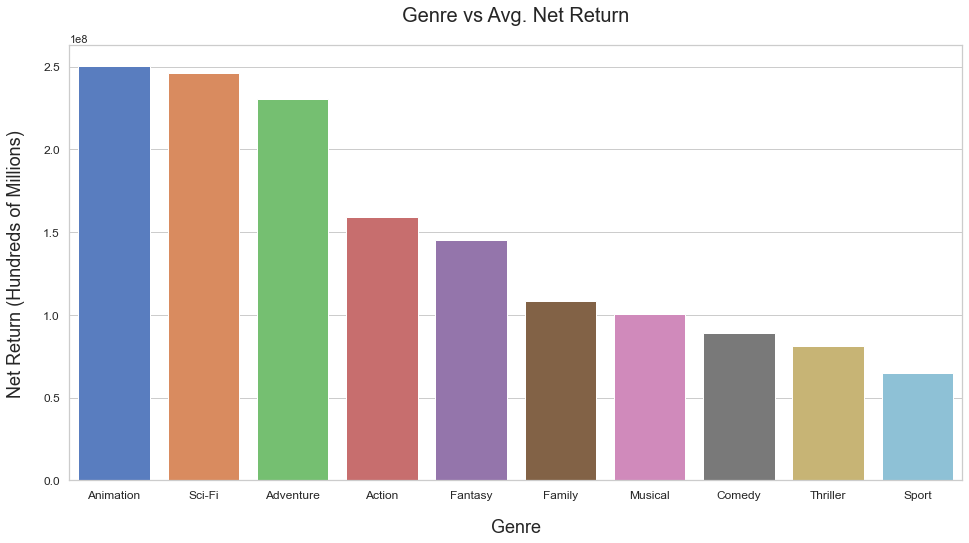

In [13]:
# visualization 1: net return bar plot

# seaborn style
sns.set(style='whitegrid')

# initialize matlab plot
fig, ax = plt.subplots(figsize=(16, 8))

# define df, x and y values
roi_vis = moviebudgets_moviebasics_mean_df.sort_values(by='net_return', ascending=False).head(10)
x_values = list(roi_vis['genres'])
y_values = list(roi_vis['net_return'])

net_return_vis = moviebudgets_moviebasics_mean_df.sort_values(by='net_return', ascending=False).head(10)

sns.barplot(x=x_values, y=y_values, data=roi_vis, palette='muted')
ax.set_title('Genre vs Avg. Net Return', fontsize = 20, pad=24)
plt.xlabel('Genre', fontsize = 18, labelpad=18)
plt.ylabel('Net Return (Hundreds of Millions)', fontsize = 18, labelpad=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('net_return_visualization.png', bbox_inches='tight')

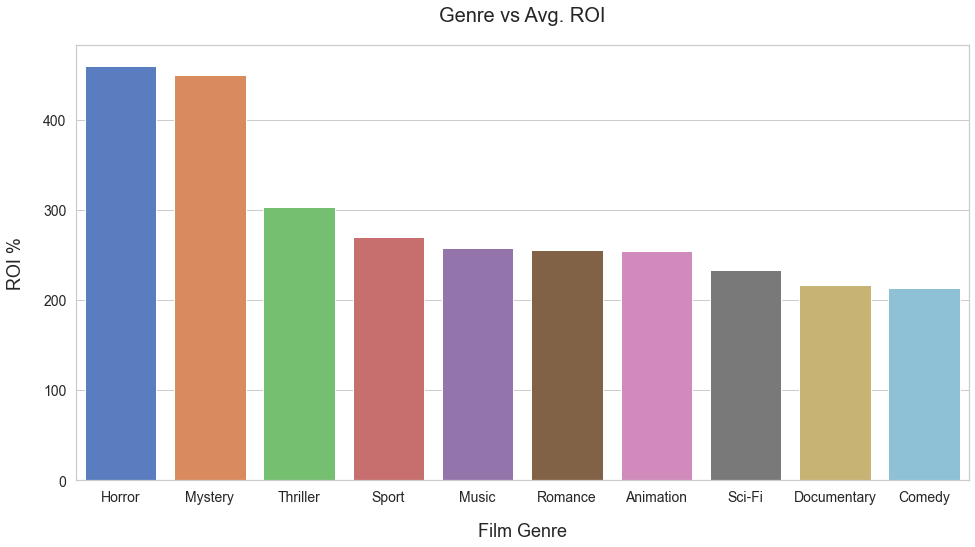

In [14]:
# visualization 2: ROI% bar plot

# seaborn style
sns.set(style='whitegrid')

# initialize matlab plot
fig, ax = plt.subplots(figsize=(16, 8))

# define df, x and y values
roi_vis = moviebudgets_moviebasics_mean_df.sort_values(by='roi_percent', ascending=False).head(10)
x_values = list(roi_vis['genres'])
y_values = list(roi_vis['roi_percent'])

# plot
sns.barplot(x=x_values, y=y_values,  data=roi_vis, palette='muted')
ax.set_title('Genre vs Avg. ROI', fontsize = 20, pad=24)
plt.xlabel('Film Genre', fontsize = 18, labelpad=18)
plt.ylabel('ROI %',  fontsize = 18, labelpad=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('roi_percent_visualization.png', bbox_inches='tight')